*[ April, 2022 ]*

*The cat translator project was part of a [2018 CASCON workshop](https://github.com/spackows/CASCON-2018_Analyzing_images).* 

*Since then, the Watson Visual Recognition tool that was used in the workshop has been discontinued.*

*So this notebook has been updated to use a Tensorflow model instead.*

# App code for the cat-translator

This notebook prototypes code for "translating" a cat's meow to English: 
- Extracting audio from a video of a cat meowing
- Clipping the meow sound
- Generating a spectrogram of that meow sound
- Classifying the spectrogram
- Playing English audio corresponding to the classification

\*Prototyping code in a notebook like this can make creating a web app later easier.

- Step 1: Install required libraries
- Step 2: Download sample video files
- Step 3: Extract meow sound
- Step 4: Create a spectrogram of the meow sound
- Step 5: Classify the spectrogram
- Step 6: Generate speech using Watson Text to Speech
- Step 7: Explore the full process - from video, to classification, to speech


## Step 1: Install and import required libraries

- [moviepy](https://zulko.github.io/moviepy/index.html) for easily working with the audio of the videos
- [librosa](https://librosa.github.io/librosa/) for creating a spectrogram of the audio snippet
- ibm-watson for working with [Watson Text to Speech API](https://cloud.ibm.com/apidocs/text-to-speech?code=python)

In [ ]:
!pip install moviepy

In [ ]:
!conda install -c conda-forge librosa

In [ ]:
!pip install "ibm-watson"

## Step 2: Download sample video files

All material for the CASCON 2018 workshop "Building AI models using Watson Studio" is stored in GitHub: [CASCON-2018_Analyzing_images](https://github.com/spackows/CASCON-2018_Analyzing_images)

To work with two sample videos, download the videos directly from GitHub to the notebook working directory.

In [4]:
import urllib.request

filename_1 = 'door.mp4'
filename_2 = 'food.mp4'
url_base = 'https://github.com/spackows/CASCON-2018_Analyzing_images/raw/master/cat-translator/sample-video/'
url_1 = url_base + filename_1
url_2 = url_base + filename_2
urllib.request.urlretrieve( url_1, filename_1 )
urllib.request.urlretrieve( url_2, filename_2 )

!ls

door.mp4  food.mp4


In [5]:
from IPython.display import Video

Video( filename_1, embed = True, width = 400 )

In [6]:
Video( filename_2, embed = True, width = 400 )

## Step 3: Extract _meow_ sound

1. Use the audio track from the videos to create a [soundarray](https://zulko.github.io/moviepy/ref/AudioClip.html?highlight=to_soundarray#moviepy.audio.AudioClip.AudioClip.to_soundarray)
2. Using a volume-based heuristic, trim the beginning and end of the audio to get a shorter audio clip of just the sound to analyze

In [7]:
from moviepy.editor import *
import re
import matplotlib.pyplot as plt


def getSoundStart( soundarray ):
    soundmax = max( [ abs(min(soundarray[:,0])), abs(max(soundarray[:,1])) ] )
    threshold = 0.3 * ( soundmax )
    i = 0
    while ( i < soundarray.shape[0] ) and ( abs( soundarray[i,0] ) < threshold ) and ( abs( soundarray[i,1] ) < threshold ):
        i += 1
    return i

def getSoundEnd( soundarray, i ):
    soundmax = max( [ abs(min(soundarray[:,0])), abs(max(soundarray[:,1])) ] )
    threshold = 0.3 * ( soundmax )
    j = ( soundarray.shape[0] - 1 )
    while ( j > i ) and ( abs( soundarray[j,0] ) < threshold ) and ( abs( soundarray[j,1] ) < threshold ):
        j -= 1
    return j

def plotSound( filename, soundarray, sound_start, sound_end ):
    plt.figure( 1, figsize=( 20, 5 ) )
    plt.plot( soundarray )
    plt.axvline( x=sound_start )
    plt.axvline( x=sound_end )
    plt.title( 'File: '+ filename )
    plt.xlabel( 'Frame number' )
    plt.ylabel( 'Channel volume' )
    plt.show()

def getTrimmedAudio( filename, verbose ):
    videoclip   = VideoFileClip( filename )
    audioclip   = videoclip.audio
    soundarray  = audioclip.to_soundarray( fps=44100, nbytes=4 )
    sound_start = getSoundStart( soundarray ) - 2000
    sound_end   = getSoundEnd( soundarray, sound_start ) + 2000
    audioclip_short = audioclip.subclip( sound_start/44100, sound_end/44100 )
    audioclip_short.duration = ( sound_end - sound_start ) / 44100
    new_filename = re.sub( '.mp4', '.wav', filename )
    audioclip_short.write_audiofile( new_filename, fps=44100, nbytes=4, verbose=False )
    if verbose:
        plotSound( filename, soundarray, sound_start, sound_end )
    return audioclip_short

MoviePy - Writing audio in door.wav


MoviePy - Done.


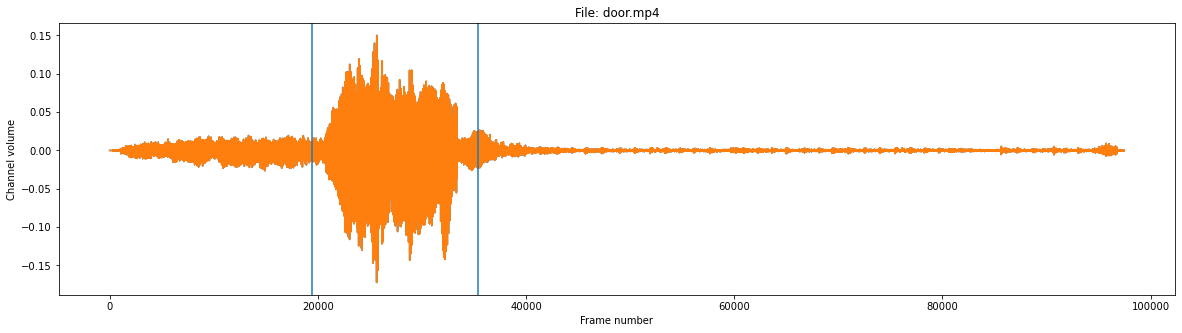

MoviePy - Writing audio in __temp__.mp3


MoviePy - Done.


In [8]:
audio_1 = getTrimmedAudio( filename_1, True )
audio_1.ipython_display( width='300' )

MoviePy - Writing audio in food.wav


MoviePy - Done.


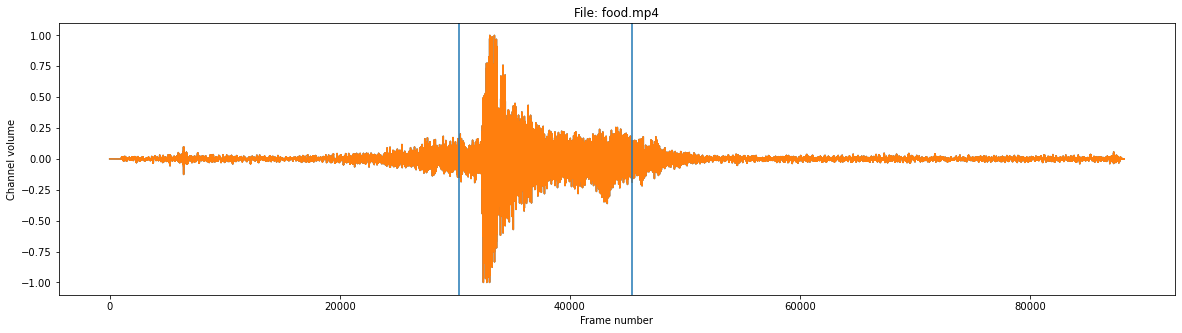

MoviePy - Writing audio in __temp__.mp3


MoviePy - Done.


In [9]:
audio_2 = getTrimmedAudio( filename_2, True )
audio_2.ipython_display( width='300' )

## Step 4: Create a spectrogram of the _meow_ sound

Create a visual representation of the short audio.

What is a "spectrogram"?  See: [Wikipedia](https://en.wikipedia.org/wiki/Spectrogram)

In [10]:
import librosa
import librosa.display
import numpy as np

def showSpectrogram( filename ):
    file_base = re.sub( '.mp4$', '', filename )
    infile = file_base + '.wav'
    y, sr = librosa.load( infile )
    plt.figure( figsize=( 10, 5 ) )
    librosa.display.specshow( librosa.amplitude_to_db( np.abs( librosa.stft( y ) ), ref=np.max ), y_axis='log', x_axis='time' )
    plt.colorbar( format='%+2.0f dB')
    plt.title( 'File: ' + filename )

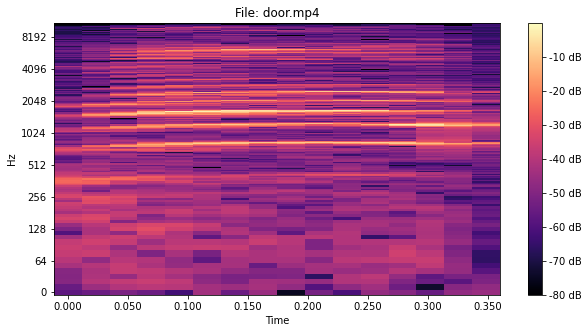

In [11]:
showSpectrogram( filename_1 )

In [12]:
from PIL import Image

def saveAsSpectrogram( filename ):
    file_base  = re.sub( '.mp4$', '', filename )
    infile     = file_base + '.wav'
    outfile    = file_base + '_lg.png'
    sm_outfile = file_base + '.spec.png'
    y, sr = librosa.load( infile )
    plt.figure( figsize=( 5, 5 ) )
    plt.title( 'File: ' + sm_outfile )
    librosa.display.specshow( librosa.amplitude_to_db( np.abs( librosa.stft( y ) ), ref=np.max ) )
    plt.savefig( outfile, bbox_inches='tight', pad_inches=0.0 )
    im = Image.open( outfile )
    sm_im = im.resize( [ 224, 224 ], resample=Image.LANCZOS )
    sm_im.save( sm_outfile, format="PNG" )
    plt.ion()
    !rm -f *_lg.png

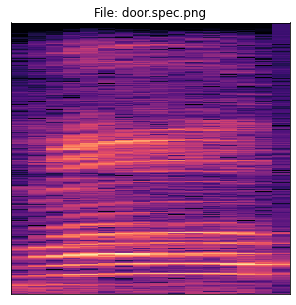

In [13]:
saveAsSpectrogram( filename_1 )

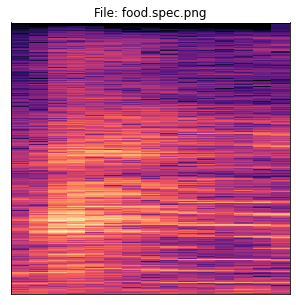

In [14]:
saveAsSpectrogram( filename_2 )

## Step 5: Classify the spectrogram

For simplicity, use the sample model from here: [Sample cat translator model](https://github.com/spackows/CASCON-2018_Analyzing_images/tree/master/cat-translator/sample-model)

In [15]:
import urllib
import zipfile

def downloadModel( url, dir ):
    zip_path, _ = urllib.request.urlretrieve( url )
    with zipfile.ZipFile( zip_path, "r" ) as f:
        f.extractall( dir )

In [16]:
model_url = "https://github.com/spackows/CASCON-2018_Analyzing_images/blob/master/cat-translator/sample-model/cat-translator-model.zip?raw=true"
model_dir = "trained-model"
downloadModel( model_url, model_dir )

!ls -R trained-model

trained-model:
assets	keras_metadata.pb  saved_model.pb  variables

trained-model/assets:

trained-model/variables:
variables.data-00000-of-00001  variables.index


In [17]:
# https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model
#
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.load_model( "trained-model" )

In [18]:
import numpy as np

def classifySpectrogram( video_filename, verbose ):
    filename = re.sub( "mp4$", "spec.png", video_filename )
    img = tf.keras.utils.load_img( filename, target_size = ( 224, 224 ) )
    img_array = tf.keras.utils.img_to_array( img )
    img_array = tf.expand_dims( img_array, 0 )
    predictions = model.predict( img_array )
    score = tf.nn.softmax( predictions[0] )
    class_names = [ "feedme", "opendoor" ]
    classification = class_names[ np.argmax( score ) ]
    if verbose:
        print( "Image: " + filename + "\n" +
               "Predicted class: " + classification + "\n" +
               "Confidence: " + str( round( 100 * np.max( score ), 3 ) ) + "%" )
    return classification

In [19]:
classifySpectrogram( filename_1, True )

Image: door.spec.png
Predicted class: opendoor
Confidence: 94.928%


'opendoor'

In [20]:
classifySpectrogram( filename_2, True )

Image: food.spec.png
Predicted class: feedme
Confidence: 100.0%


'feedme'

## Step 6: Generate speech using Watson Text to Speech

Use the [Watson Text to Speech Python client API](https://cloud.ibm.com/apidocs/text-to-speech?code=python) to generate speech for each class the model has been trained to recognize: "feedme" and "opendoor".

Then save each audio to a file to be played when needed.

### Prerequisite

1. Create an instance of [Watson Text to Speech](https://cloud.ibm.com/catalog/services/text-to-speech)
2. Look up credentials for your Watson Text to Speech service instance

In [21]:
apikey = "" # <-- PASTE YOUR APIKEY HERE
service_url = "" # <-- PASTE YOUR SERVICE URL HERE

In [22]:
from ibm_watson import TextToSpeechV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

authenticator = IAMAuthenticator( apikey )
text_to_speech = TextToSpeechV1( authenticator = authenticator )
text_to_speech.set_service_url( service_url )

In [23]:
# https://cloud.ibm.com/apidocs/text-to-speech?code=python#synthesize
#
with open( "feedme-speech.wav", "wb" ) as audio_file:
    audio_file.write( text_to_speech.synthesize( "I would like some food, please.", voice = "en-GB_KateV3Voice", accept = "audio/wav" ).get_result().content )

with open( "opendoor-speech.wav", "wb") as audio_file:
    audio_file.write( text_to_speech.synthesize( "Will someone open this door, please.", voice = "en-GB_KateV3Voice", accept = "audio/wav" ).get_result().content )

In [24]:
import IPython
IPython.display.Audio( "feedme-speech.wav" )

In [25]:
IPython.display.Audio( "opendoor-speech.wav" )

## Step 7: Explore the full process - from video, to classification, to speech

In [26]:
def translateMeow( filename ):
    print( filename )
    getTrimmedAudio( filename, False )
    saveAsSpectrogram( filename )
    classification = classifySpectrogram( filename, False )
    audio_filename = classification + "-speech.wav"
    return audio_filename   

### Test 1: Open the door

In [30]:
# Given the video of the cat wanting the door to open...
#
Video( filename_1, embed = True, width = 400 )

door.mp4
MoviePy - Writing audio in door.wav


MoviePy - Done.


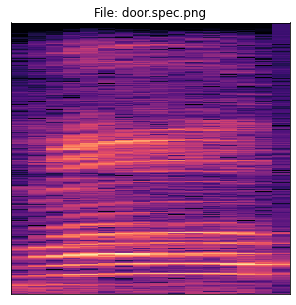

In [31]:
# figure out what the cat wants by classifying a spectrogram of the
# meow sound, then "translate" that to the correct English audio.
#
IPython.display.Audio( translateMeow( filename_1 ) )

### Test 2: Feed me

In [32]:
# Given the video of the cat wanting to be fed...
#
Video( filename_2, embed = True, width = 400 )

food.mp4
MoviePy - Writing audio in food.wav


MoviePy - Done.


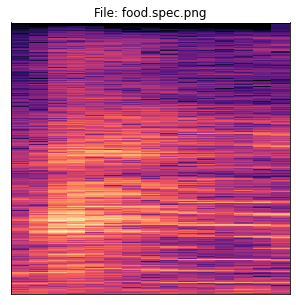

In [33]:
# figure out what the cat wants by classifying a spectrogram of the
# meow sound, then "translate" that to the correct English audio.
#
IPython.display.Audio( translateMeow( filename_2 ) )